We consider a pure exchange economy with $N$ agents and $n$ commodities.
Each agent $i$ has an endowment $e_i \in {\bf{R}}_+^n$ and a utility 
function $U_i(r_i)$, where $U_i: {\bf{R}}_+^n \to {\bf{R}}$ is a concave nondecreasing. These primitives define the exchange economy $\mathcal{E}=\left( (U_i, e_i)_{i \in [N]}\right)$. Denote the total endowment by $E = \sum_{i=1}^N e_i$.


**Walrasian equilibrium** for exchange economy $\mathcal{E}$ is a vector $\left( \nu, (x_i)_{i \in [N]}\right)$, such that 
* every agent's consumption  $x_i\in {\bf{R}}^n$ maximizes her utility given prices $\nu \in {\bf{R}}_+^n$
$$
\begin{array}{ll}
\mbox{maximize} & U_i(x_i)  \\
\mbox{subject to} & \nu^T x_i \leq \nu^T e_i \\
& x_i \geq  0,
\end{array}
$$
* markets clear $\sum_{i=1}^N x_i \leq \sum_{i=1}^N e_i=E$.

The goal of this notebook is to see the performance of OSBDO when applied to the action directed Walrasian Equilibrium (over primal variables $x_1, \ldots, x_N$) and price directed Walrasian Equilibrium (over dual variable $\nu$). This corresponds to the primal formulation of the problem, given by
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^N -U_i(x_i)  \\
\mbox{subject to} & \sum_{i=1}^N x_i = E \\
& x_i  \geq 0, \quad i=1,\ldots, N,
\end{array}
$$
and negated dual formulation of the problem, given by  
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^N \underset{x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right ) + \nu_1^T E   \\
\mbox{subject to} & \nu_1=\cdots=\nu_N.
\end{array}
$$


In [1]:
import cvxpy as cp
import numpy as np
import osbdo as ob

from scipy import stats
import time
from scipy import stats

In [2]:
import matplotlib.pyplot as plt

In [3]:
def get_rel_diff(a,b):
    return np.linalg.norm(a-b) / min(np.linalg.norm(a), np.linalg.norm(b)) 

In [4]:
def check_subgrads(agent, ntimes):
    l, u = agent.lwb, agent.upb
    n = agent.dim
    for _ in range(ntimes):
        v = l + np.multiply(np.random.rand(n), u-l)
        point = agent.query(v=v)
        linear = lambda x: point.f + point.q @ (x - point.x)
        for _ in range(10):
            test = l + np.multiply(np.random.rand(n), u-l)
            a = linear(test)
            b = agent.query(v=test).f + 10**(-6)
            assert a <= b, print(a, b, b-a)
    print("passed")

# Create instance of the problem

In [5]:
N = 50

params, R = ob.ra_params(num_resources=N, num_agents=N, num_participants=N)

In [6]:
E = R
n = params[0]['dimension']

In [7]:
for j in range(n):
    count = 0
    for i in range(N):
        A = params[i]["A_list"][0]
        if A[0,j] > 0:
            count += 1
    assert count > 0

# Centralized solution

In [8]:
dim = params[0]['dimension']
z = cp.Variable(len(params)*dim)
num_agents = len(params)
constraints = []
f = 0
xi_list = []
start = time.time()
for i in range(num_agents):
    xi = z[(i*dim):((i+1)*dim)]
    X = cp.Variable((len(params[i]['A_list']), dim))
    for j in range(len(params[i]['A_list'])):
        f += -cp.geo_mean(params[i]['A_list'][j] @ X[j].T + params[i]['b_list'][j])
    constraints += [cp.sum(X,axis=0) <= xi, \
                    X>=0, \
                    xi<=params[i]['upper_bound'], 
                    xi>=params[i]['lower_bound']]
    xi_list.append(xi)
constraints += [sum(xi_list)==R]
prob_cvx = cp.Problem(cp.Minimize(f), constraints)
prob_cvx.solve(solver='ECOS')
print(f"elapsed time =  {time.time()-start}")

h_cvx, x_cvx = f.value, z.value
nu_cvx = constraints[-1].dual_value
print(f"{h_cvx = }")

elapsed time =  1.2062928676605225
h_cvx = -467.79716766696


### Initial upper bound on $\nu$
$$
\nu^\star_j \leq \nu_{\max,j} ~=~ \min_{i:{A_{i, \cdot j}}\neq 0 } \quad \left [ (1/m) \mbox{geomean}(A_i E + b_i) ~ A_i^T b_i^{-1} \right ]
$$

In [9]:
nu_upb = np.inf * np.ones(n)
m = params[0]["A_list"][0].shape[0]

for i  in  range(N):
    A = params[i]["A_list"][0]
    b = params[i]["b_list"][0]
    assert (A>=0).all() and (b>=0).all()
    Ui = stats.mstats.gmean(A@E + b)
    grad_i = (Ui/m) * A.T @ b**(-1)
    
    for j in range(n):
        if A[0,j] > 0:
            nu_upb[j] = min(nu_upb[j], grad_i[j])

In [10]:
nu_cvx.min(), nu_cvx.max(), nu_upb.min(), nu_upb.max()

(0.6569293287114274, 0.9102318956649578, 9.511224953406211, 27.597578921853007)

In [11]:
assert (nu_cvx <= nu_upb + 10**(-8) ).all(), print("wrong bound on nu")

# Action directed Walrasian equilibrium
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^N -U_i(x_i)  \\
\mbox{subject to} & \sum_{i=1}^N x_i = E \\
& x_i  \geq 0, \quad i=1,\ldots, N,
\end{array}
$$
where $U_i(x_i)= \left (\prod_{k=1}^m (A_{i,k}x_{i} + b_{i,k})\right)^{1/m}$.

## OSBDO oracle-structured form 
We can solve the problem using OSBDO, by taking the agent function
$$
f_i(x_i) = -U_i(x_i),$$
and the structured objective function $g$,
$$
g(x) = \left\{ \begin{array}{ll} 0 &
x_1 + \cdots + x_N = E, \quad x_i \geq 0, \quad i=1, \ldots, N\\
\infty & \mbox{otherwise}.
\end{array} \right.
$$

In [12]:
rel_gap = 0.01

# OSBDO solution

In [13]:
agents = ob.ra_agents(params=params)

domain = [sum([agents[i].x for i in range(len(agents))])==R]
g = ob.Coupling(agents = agents, function = cp.Constant(0), domain = domain)

prob = ob.Problem(agents = agents, g = g)

In [14]:
start = time.time()
x_agent, x_global = prob.solve(rel_gap=rel_gap, abs_gap=10**(-3), max_iter=50)
print(f"elapsed time =  {time.time()-start}")

k=0, rel_gap=31.213382604688135, L=-10419.203406474478, U=-323.4433196394014
k=1, rel_gap=0.4845424371401474, L=-480.16533401417666, U=-323.4433196394014
k=2, rel_gap=0.19507787381930697, L=-477.10049117823314, U=-399.2212571499501
k=3, rel_gap=0.10381038131768544, L=-476.4021112919189, U=-431.59778106381714
k=4, rel_gap=0.06898180200738095, L=-476.0240786713894, U=-445.3060639362527


/Users/parshakova.tanya/opt/anaconda3/envs/py38/lib/python3.8/site-packages/cvxpy/problems/problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


k=5, rel_gap=0.05276148212653877, L=-474.9488061488716, U=-451.14569084489375
k=6, rel_gap=0.045773579896904906, L=-474.82342011894207, U=-454.0403670991109
k=7, rel_gap=0.0398494303320606, L=-473.29045819126003, U=-455.1528753928554
k=8, rel_gap=0.03747028231317991, L=-473.18550884111517, U=-456.095482355489
k=9, rel_gap=0.030021564242344454, L=-470.1283599394179, U=-456.4257451107166
k=10, rel_gap=0.018898404454328832, L=-470.1010544352988, U=-461.3816768974739
k=11, rel_gap=0.014162670872323764, L=-469.935660829207, U=-463.3730606796991
k=12, rel_gap=0.01053926885133906, L=-469.0439414385151, U=-464.1521174844284
k=13, rel_gap=0.008091767879346401, L=-469.02280537896127, U=-465.2580452726168
elapsed time =  127.35884594917297


# $L^k, \quad h^\star, \quad U^k$

In [15]:
prob.lower_bnd[-1], h_cvx, prob.upper_bnd[-1]

(-469.02280537896127, -467.79716766696, -465.2580452726168)

## Plot

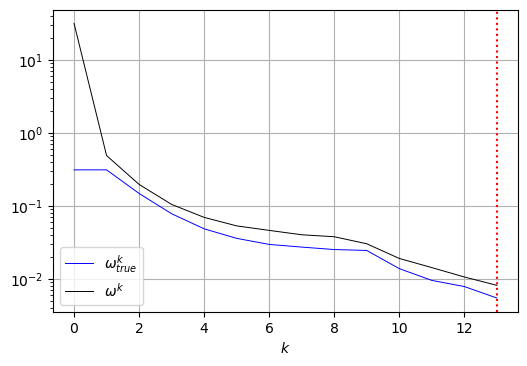

In [16]:
ob.plot_true_rel_gap_uk(lk = prob.lower_bnd, uk = prob.upper_bnd, h_true = h_cvx)

# Price directed Walrasian equilibrium
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^N \underset{x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right ) + \nu_1^T E   \\
\mbox{subject to} & \nu_1=\cdots=\nu_N,
\end{array}
$$
where $U_i(x_i)= \left (\prod_{k=1}^m (A_{i,k}x_{i} + b_{i,k})\right)^{1/m}$.

## OSBDO oracle-structured form 

We can solve the problem in the dual variable using OSBDO, by taking the agent function
$$
f_i(\nu_i) = \underset{E \geq x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right ),
$$
and $g$ the indicator function for consensus plus the total price for all  commodities,
$$
g(x) = \left\{ \begin{array}{ll}  \nu_1^T E & \nu_1 = \cdots = \nu_N\\
\infty & \mbox{otherwise}. 
\end{array}\right.
$$
Note that $f_i$ is convex as a pointwise supremum over linear functions in $\nu_i$.

In [17]:
class GeoMeanConj(ob.Agent):
    """
    fi(nu_i)  = \max_{E\geq x_i\geq 0} ( U_i(x_i) - \nu_i^Tx_i )
    """
    def _construct_params(self):
        self.A = self.params['A']
        self.b = self.params['b']
        self.E = self.params['E']
        self.nu_max = self.params['nu_max']

    def query(self, *, v, solver='ECOS'):
        x = cp.Variable((self.dim), nonneg=True)
        f = cp.geo_mean(self.A @ x + self.b) - v @ x
        prob = cp.Problem(cp.Maximize(f), [x <= self.E])
        prob.solve(solver=cp.MOSEK)
        f = f.value
        q = -x.value
        return ob.Point(x=v, q=q, f=f)
    
    def get_init_minorant(self):
        lwb = stats.mstats.gmean(self.b, axis=None) - self.E @ self.nu_max
        return cp.Constant(lwb)
    
def get_total_obj(agents, xs):
    obj = 0
    for agent in agents:
        obj += stats.mstats.gmean(agent.A @ xs[i] + agent.b, axis=None)
    return -obj

In [18]:
agents = [0]*N
nu_params = []
for i  in  range(N): 
    nu_params += [{ 'dimension':n, 
                    'lower_bound':0, 
                    'upper_bound':None,
                    'nu_max':nu_upb,
                    'E':E,
                    'A':params[i]["A_list"][0],
                    'b':params[i]["b_list"][0]}]
    
    agents[i] = GeoMeanConj(nu_params[i])

In [19]:
domain = [agents[0].x == agent.x for agent in agents[1:]]

g = ob.Coupling(agents = agents, function = agents[0].x @ E, domain = domain)

In [20]:
prob = ob.Problem(agents = agents, g = g)

# OSBDO solution

In [21]:
start = time.time()
x_agent, x_global = prob.solve(rel_gap=rel_gap, abs_gap=10**(-3), max_iter=50, \
                               solver="OSQP")
print(f"elapsed time =  {time.time()-start}")

k=0, rel_gap=inf, L=-453494.66251604824, U=10419.203175712555
k=1, rel_gap=inf, L=-444187.5043394375, U=10419.203175712555
k=2, rel_gap=inf, L=-417201.9043293528, U=4761.845400539485
k=3, rel_gap=inf, L=-407896.82123752334, U=4761.845400539485


/Users/parshakova.tanya/opt/anaconda3/envs/py38/lib/python3.8/site-packages/cvxpy/problems/problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


k=4, rel_gap=13.42138570035397, L=330.19333228308335, U=4761.845400539485
k=5, rel_gap=6.696668616028355, L=333.16868470789166, U=2564.288959434676
get_hat_h_star ECOS fail
k=6, rel_gap=3.4935991280648513, L=330.5888968002662, U=1485.5339784095972
k=7, rel_gap=1.847380581858283, L=333.17927609971923, U=948.68820104394
k=8, rel_gap=1.3090017667404814, L=334.94132969345105, U=773.3801220165846
k=9, rel_gap=0.8005065449141214, L=337.483571110037, U=607.641378584612
k=10, rel_gap=0.4574102978299307, L=398.7611515713078, U=581.1586086745458
k=11, rel_gap=0.23766301940144466, L=410.27987047560333, U=507.78822329246884
k=12, rel_gap=0.16459133347009242, L=430.2213608044142, U=501.0320682665305
k=13, rel_gap=0.02016666678770784, L=463.9401535216592, U=473.29628000716855
k=14, rel_gap=0.01156274597013166, L=464.36437596221555, U=469.73370327904536
k=15, rel_gap=0.004645030884795906, L=466.2992364412114, U=468.4652107960376
elapsed time =  91.59903717041016


# $L^k, \quad h^\star, \quad U^k$

In [22]:
prob.lower_bnd[-1], -h_cvx, prob.upper_bnd[-1]

(466.2992364412114, 467.79716766696, 468.4652107960376)

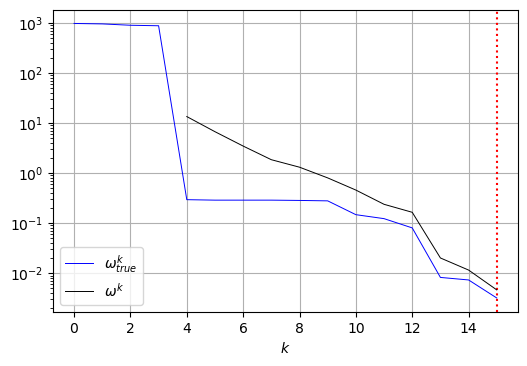

In [23]:
ob.plot_true_rel_gap_uk(lk = -np.array(prob.upper_bnd), uk = -np.array(prob.lower_bnd), h_true = h_cvx)